In [137]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import cvxpy as cp  # for optimization
import pypfopt as ppo


Extra Data Preview (Raw):
      TICKERS  PE Ratios   DER  Sales in crore(2024)   Sales in crore(2023)  \
0    ADANIENT      73.49  0.34               138,175                  22849   
1  ADANIPORTS      24.80  0.88                26,711                  20852   
2  APOLLOHOSP      74.61  0.98                19,059                  16613   
3  ASIANPAINT      54.23  0.14                35,459                  34489   
4    AXISBANK      11.80  1.46               137,989                 105797   

        SMA  
0  2411.530  
1  1176.402  
2  6819.230  
3  2349.571  
4  1067.991  

Column Names:
Index(['TICKERS', 'PE Ratios', 'DER', ' Sales in crore(2024) ',
       'Sales in crore(2023)', 'SMA'],
      dtype='object')

Cleaned Data Preview:
      TICKERS  Sales in crore(2024)  Sales in crore(2023)      SMA
0    ADANIENT              138175.0               22849.0  2411.53
1  ADANIPORTS               26711.0               20852.0  1176.40
2  APOLLOHOSP               19059.0               

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustered Data Preview:
       TICKERS  Cluster
0     ADANIENT        0
1   ADANIPORTS        1
2   APOLLOHOSP        0
3   ASIANPAINT        1
4     AXISBANK        2
5   BAJAJ-AUTO        0
6   BAJFINANCE        0
7   BAJAJFINSV        2
8          BEL        1
9   BHARTIARTL        2
10       CIPLA        1
11   COALINDIA        2
12     DRREDDY        1


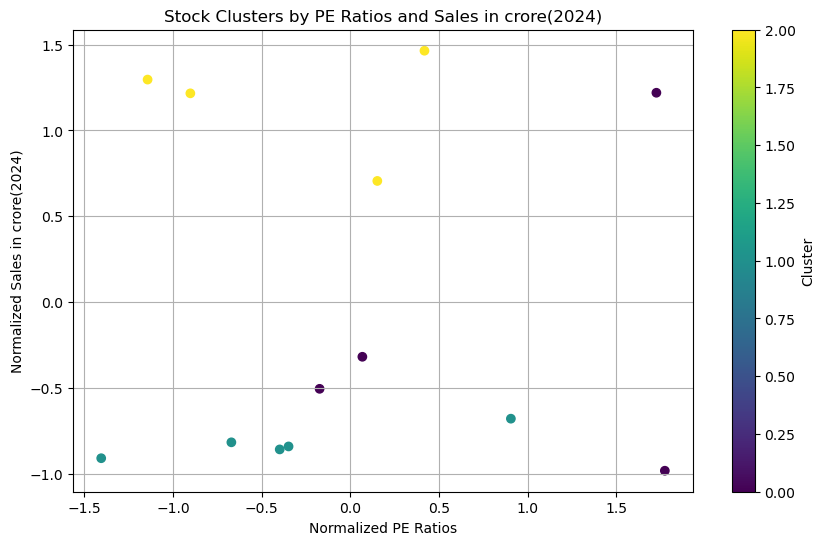


Top Stocks in Cluster 0:
      TICKERS      Rank
0    ADANIENT  2.394759
2  APOLLOHOSP  2.270597
6  BAJFINANCE  1.808150
5  BAJAJ-AUTO  0.700868

Top Stocks in Cluster 1:
       TICKERS      Rank
3   ASIANPAINT -0.502096
1   ADANIPORTS -1.742887
10       CIPLA -2.388609
12     DRREDDY -2.687005
8          BEL -3.966166

Top Stocks in Cluster 2:
       TICKERS      Rank
7   BAJAJFINSV  3.464056
9   BHARTIARTL  1.772468
4     AXISBANK  0.177217
11   COALINDIA -1.301352


In [260]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Address MKL memory leak on Windows by limiting threads
os.environ["OMP_NUM_THREADS"] = "1"

# Load the Extra Data file
extra_data_path = 'C:/Users/DELL/Desktop/SEM6/Artificial Intelligence/Project2/Extra data.csv' 
extra_data = pd.read_csv(extra_data_path)

# Display the raw data and column names for inspection
print("\nExtra Data Preview (Raw):")
print(extra_data.head())
print("\nColumn Names:")
print(extra_data.columns)

# Clean column names to remove leading/trailing spaces
extra_data.columns = extra_data.columns.str.strip()

# Clean and preprocess the Sales columns and round off SMA values
extra_data['Sales in crore(2024)'] = extra_data['Sales in crore(2024)'].astype(str).str.replace(',', '').astype(float)
extra_data['Sales in crore(2023)'] = extra_data['Sales in crore(2023)'].astype(str).str.replace(',', '').astype(float)
extra_data['SMA'] = extra_data['SMA'].round(2)

# Verify cleaned data
print("\nCleaned Data Preview:")
print(extra_data[['TICKERS', 'Sales in crore(2024)', 'Sales in crore(2023)', 'SMA']].head())

# Normalize the data for clustering (to balance scales)
def normalize_data(df, columns):
    normalized_df = df.copy()
    for column in columns:
        normalized_df[column] = (df[column] - df[column].mean()) / df[column].std()
    return normalized_df

# Columns to normalize for analysis
columns_to_normalize = ['PE Ratios', 'DER', 'Sales in crore(2024)', 'Sales in crore(2023)', 'SMA']
normalized_data = normalize_data(extra_data, columns_to_normalize)

# Clustering stocks into groups using k-means
def cluster_stocks(normalized_df, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # Set n_init explicitly
    clusters = kmeans.fit_predict(normalized_df[columns_to_normalize])
    normalized_df['Cluster'] = clusters
    return normalized_df, kmeans

# Cluster the stocks
clustered_data, kmeans_model = cluster_stocks(normalized_data)

# Display the clustered data
print("\nClustered Data Preview:")
print(clustered_data[['TICKERS', 'Cluster']])

# Visualization of clusters
plt.figure(figsize=(10, 6))
plt.scatter(normalized_data['PE Ratios'], normalized_data['Sales in crore(2024)'], c=clustered_data['Cluster'], cmap='viridis')
plt.title('Stock Clusters by PE Ratios and Sales in crore(2024)')
plt.xlabel('Normalized PE Ratios')
plt.ylabel('Normalized Sales in crore(2024)')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

# Rank stocks within clusters based on normalized metrics
def rank_stocks(clustered_df, cluster_num):
    cluster_data = clustered_df[clustered_df['Cluster'] == cluster_num].copy()  # Use .copy() to avoid warnings
    cluster_data['Rank'] = cluster_data[['PE Ratios', 'DER', 'Sales in crore(2024)', 'SMA']].sum(axis=1)
    ranked_data = cluster_data.sort_values(by='Rank', ascending=False)  # High rank = better
    return ranked_data

# Rank stocks in each cluster and display recommendations
for cluster_id in clustered_data['Cluster'].unique():
    print(f"\nTop Stocks in Cluster {cluster_id}:")
    top_stocks = rank_stocks(clustered_data, cluster_id)
    print(top_stocks[['TICKERS', 'Rank']].head())

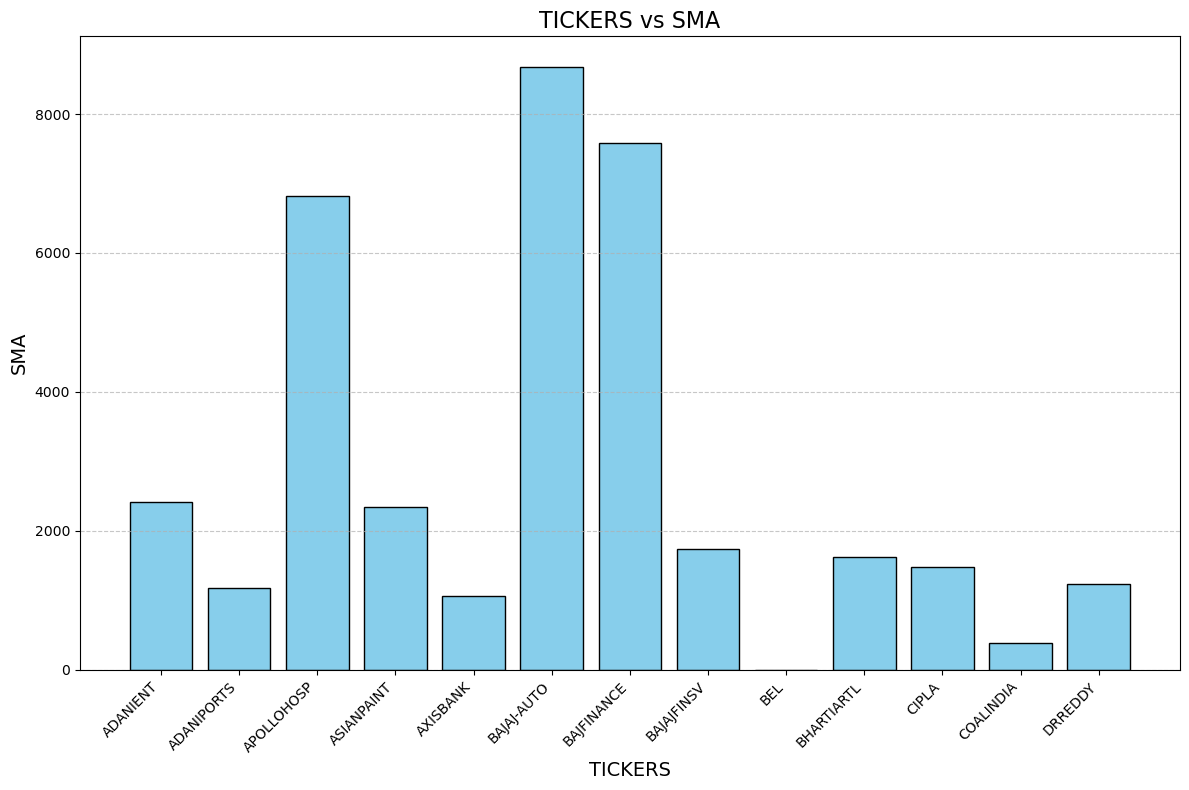

In [264]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Extra Data file
extra_data_path = 'C:/Users/DELL/Desktop/SEM6/Artificial Intelligence/Project2/Extra data.csv'  # Replace with your file path
extra_data = pd.read_csv(extra_data_path)

# Ensure TICKERS and SMA are properly formatted
extra_data['SMA'] = extra_data['SMA'].round(2)  # Round off SMA for clarity
extra_data['TICKERS'] = extra_data['TICKERS'].astype(str)  # Ensure TICKERS are strings

# Plotting a bar graph for TICKERS vs SMA
plt.figure(figsize=(12, 8))
plt.bar(extra_data['TICKERS'], extra_data['SMA'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')  # Rotate ticker labels for better readability
plt.title('TICKERS vs SMA', fontsize=16)
plt.xlabel('TICKERS', fontsize=14)
plt.ylabel('SMA', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the bar graph
plt.show()

In [266]:
import pandas as pd
import numpy as np

# Load the Extra Data file
extra_data_path = 'C:/Users/DELL/Desktop/SEM6/Artificial Intelligence/Project2/Extra data.csv'  # Replace with your file path
extra_data = pd.read_csv(extra_data_path)

# Clean column names to remove leading/trailing spaces
extra_data.columns = extra_data.columns.str.strip()

# Clean and preprocess the Sales columns and round off SMA values
extra_data['Sales in crore(2024)'] = extra_data['Sales in crore(2024)'].astype(str).str.replace(',', '').astype(float)
extra_data['Sales in crore(2023)'] = extra_data['Sales in crore(2023)'].astype(str).str.replace(',', '').astype(float)
extra_data['SMA'] = extra_data['SMA'].round(2)

# Define the scoring function based on weighted metrics
def score_function(row):
    # Define weights for each metric
    weights = {
        'PE Ratios': -0.3,  # Lower is better, so negative weight
        'DER': -0.2,  # Lower is better, so negative weight
        'Sales in crore(2024)': 0.4,  # Higher is better
        'SMA': 0.5  # Higher is better
    }
    # Compute the weighted score
    score = (
        weights['PE Ratios'] * row['PE Ratios'] +
        weights['DER'] * row['DER'] +
        weights['Sales in crore(2024)'] * row['Sales in crore(2024)'] +
        weights['SMA'] * row['SMA']
    )
    return score

# Hill Climbing Algorithm
def hill_climbing(data):
    # Start with a random stock
    current_stock = data.sample(1).iloc[0]
    current_score = score_function(current_stock)

    print(f"Initial Stock: {current_stock['TICKERS']}, Score: {current_score:.2f}")

    # Iterate through potential moves (stocks) and improve
    for _ in range(100):  # Limit iterations to avoid infinite loops
        # Randomly pick a neighboring stock (another row)
        next_stock = data.sample(1).iloc[0]
        next_score = score_function(next_stock)

        # If the next stock has a better score, move to it
        if next_score > current_score:
            current_stock = next_stock
            current_score = next_score

            print(f"Moved to Stock: {current_stock['TICKERS']}, Score: {current_score:.2f}")

    return current_stock

# Run the Hill Climbing algorithm
best_stock = hill_climbing(extra_data)
print("\nBest Stock Selected:")
print(best_stock[['TICKERS', 'PE Ratios', 'DER', 'Sales in crore(2024)', 'SMA']])

Initial Stock: ADANIPORTS, Score: 11264.98
Moved to Stock: COALINDIA, Score: 57123.55
Moved to Stock: BHARTIARTL, Score: 61365.01

Best Stock Selected:
TICKERS                 BHARTIARTL
PE Ratios                    42.79
DER                           1.25
Sales in crore(2024)      151418.0
SMA                         1621.8
Name: 9, dtype: object
